In [1]:
#pip install tf_keras


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-05-22 04:27:50.190640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 04:27:50.190729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 04:27:50.322703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print(tf.__version__)

2.15.0


In [7]:
import json 

data = []
# Read the JSON file
with open("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", 'r') as file:
    for line in file:
        # Parse each JSON object
        data.append(json.loads(line))


In [8]:
len(data)

26709

In [9]:
data[:2]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0}]

In [10]:
# Convert JSON data to a DataFrame
df = pd.DataFrame(data)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [11]:
df = df.drop(columns=["article_link"])
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [12]:
df.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

<Axes: xlabel='is_sarcastic'>

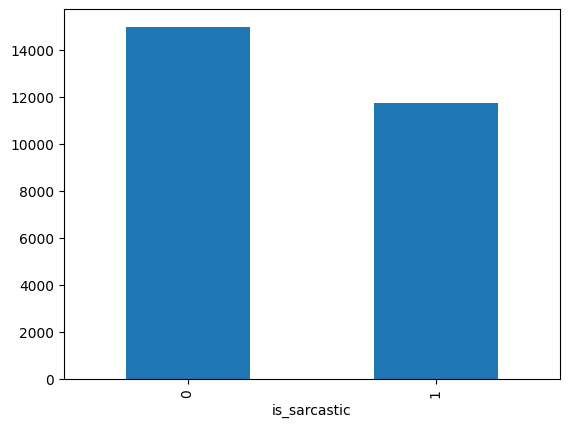

In [13]:
counts = df['is_sarcastic'].value_counts()
counts.plot(kind='bar')

In [14]:
X = df['headline'].to_numpy()
y = df['is_sarcastic'].to_numpy()

In [15]:
X.shape,y.shape

((26709,), (26709,))

In [16]:
# First split: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,shuffle=True)

# Second split: Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42,shuffle=True)

In [17]:
len(X_train), len(X_test), len(X_val), len(y_train), len(y_test), len(y_val)

(18161, 5342, 3206, 18161, 5342, 3206)

In [18]:
X_train[:2],y_train[:2]

(array(['this supreme court case could significantly weaken teachers unions',
        'a century later the same old thrill'], dtype=object),
 array([0, 0]))

# Base Model using Naive Bayes

In [19]:
X_train.shape,y_train.shape

((18161,), (18161,))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_nb = Pipeline([
                      ("tf-idf", TfidfVectorizer()),
                      ("clf", MultinomialNB())
    ])

# Fit the pipeline to the training data
model_nb.fit(X=X_train, 
            y=y_train);

In [21]:
baseline_score = model_nb.score(X_val, y_val)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 82.97%


In [22]:
baseline_score = model_nb.score(X_test, y_test)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 81.39%


# Using RNN LSTM Bidirection Model

In [23]:
# How long is each sentence - First 5 sentences?
sent_lens = [len(sentence.split()) for sentence in X_train]
sent_lens[:5]

[9, 7, 12, 6, 7]

In [24]:
# Find average number of tokens (words) in training dataset
round(sum([len(i.split()) for i in X_train])/len(X_train))

10

In [25]:
# another way to find average
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

9.838995650019273

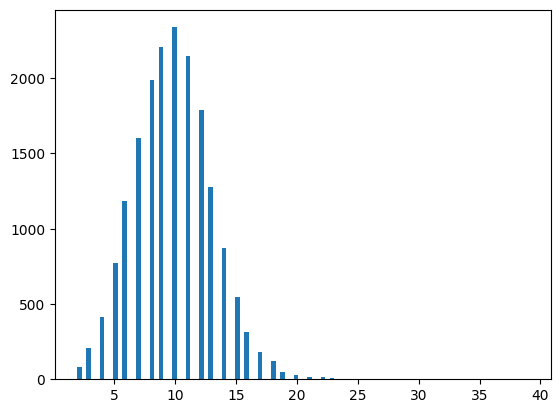

In [26]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=100);

In [27]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

15

In [28]:
unique_words=set()
[unique_words.update(sentence.split()) for sentence in X_train]

unique_words_list = list(unique_words)
print(unique_words_list[:5])
len(unique_words)

['ride', 'diagram', 'strains', 'nitrogen', 'lamp']


29405

# Tokenize the word

In [29]:
max_vocab_length = 10000
sentence_length = 15
no_of_classes = 1

In [30]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization


text_vectorizer = TextVectorization(max_tokens=max_vocab_length, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=sentence_length) 
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [31]:

# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [32]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
measles cases could triple even with just a small decline in vaccinations      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[4752, 1754,   87, 3874,  161,   10,   35,    7,  658, 4992,    5,
           1,    0,    0,    0]])>

In [33]:

_# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'to', 'of', 'the']
Bottom 5 least common words: ['interrupt', 'interrogator', 'internship', 'interns', 'internment']


# Creating an embedding layer

In [34]:
batch_size=32

In [35]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=sentence_length, # how long is each input
                             name="embedding_1") 


In [36]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [37]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [38]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_rnn_embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             embeddings_initializer="uniform", #
                             input_length=sentence_length, 
                             name="embedding_1") 


# Create LSTM Bidirection model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_rnn_embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x) # (you can stack RNN cells as long as return_sequences=True)
x = layers.Bidirectional(layers.LSTM(64))(x)
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(no_of_classes, activation="sigmoid")(x)
model_bidirectional = tf.keras.Model(inputs, outputs, name="model_rnn_LSTM")

(None, 15, 128)
(None, 128)


In [39]:
# Compile model
model_bidirectional.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
model_bidirectional.summary()

Model: "model_rnn_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                    

In [41]:

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

def create_model_checkpoint(model_name,patience=5):
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=patience)
    checkpoint_callback = ModelCheckpoint(filepath=f"{model_name}.keras", monitor='val_accuracy', save_best_only=True)
    return [early_stopping_callback,checkpoint_callback]

In [70]:
# Fit the model
model_bidirectional_history = model_bidirectional.fit(train_dataset,
                              steps_per_epoch=int(len(train_dataset)//batch_size), 
                              epochs=100,
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset)//batch_size),
                              callbacks=create_model_checkpoint(model_name="model_lstm_bidir",patience=10))

print("Model training done")

Epoch 1/100
17/17 [==============================] - 0s 22ms/step - loss: 0.2834 - accuracy: 0.8732 - val_loss: 0.3779 - val_accuracy: 0.8542
Epoch 2/100
17/17 [==============================] - 0s 10ms/step - loss: 0.2755 - accuracy: 0.8824 - val_loss: 0.3496 - val_accuracy: 0.8542
Epoch 3/100
17/17 [==============================] - 0s 10ms/step - loss: 0.2131 - accuracy: 0.9026 - val_loss: 0.3533 - val_accuracy: 0.8542
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 0.2267 - accuracy: 0.8989 - val_loss: 0.3942 - val_accuracy: 0.8542
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 0.2337 - accuracy: 0.9026 - val_loss: 0.3635 - val_accuracy: 0.8438
Epoch 6/100
17/17 [==============================] - 0s 21ms/step - loss: 0.2189 - accuracy: 0.9118 - val_loss: 0.4082 - val_accuracy: 0.8750
Epoch 7/100
17/17 [==============================] - 0s 10ms/step - loss: 0.2229 - accuracy: 0.8971 - val_loss: 0.3960 - val_accuracy: 0.8542
Epoch 

In [71]:
# Loading the best model
best_model_2 =  tf.keras.models.load_model('model_lstm_bidir.keras')
loss,accuracy = best_model_2.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

167/167 [==============================] - 3s 5ms/step - loss: 0.3777 - accuracy: 0.8547
Model loss on the test set: 0.37771186232566833
Model accuracy on the test set: 85.47%


# Using Pre Trained Embedded layer

In [72]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [73]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
x = layers.Dense(64, activation="relu")(x)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(no_of_classes, activation="sigmoid")(x) # create the output layer
model_pre_trained = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_pre_trained.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [74]:

model_pre_trained.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256871809 (979.89 MB)
Trainable params: 73985 (289.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________

In [75]:
model_pre_trained.fit(train_dataset,
                      steps_per_epoch=int(len(train_dataset)//batch_size), 
                      epochs=100,
                      validation_data=valid_dataset,
                      validation_steps=int(len(valid_dataset)//batch_size),
                      callbacks=create_model_checkpoint(model_name="model_pretrained_layer",patience=10))

print("Model training done")

Epoch 1/100
17/17 [==============================] - 7s 290ms/step - loss: 0.6840 - accuracy: 0.5533 - val_loss: 0.6804 - val_accuracy: 0.5417
Epoch 2/100
17/17 [==============================] - 7s 422ms/step - loss: 0.6716 - accuracy: 0.5368 - val_loss: 0.6619 - val_accuracy: 0.6250
Epoch 3/100
17/17 [==============================] - 6s 372ms/step - loss: 0.6324 - accuracy: 0.6857 - val_loss: 0.6199 - val_accuracy: 0.6771
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 0.5677 - accuracy: 0.7647 - val_loss: 0.5745 - val_accuracy: 0.6771
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 0.5279 - accuracy: 0.7243 - val_loss: 0.5608 - val_accuracy: 0.6771
Epoch 6/100
17/17 [==============================] - 6s 392ms/step - loss: 0.5011 - accuracy: 0.7482 - val_loss: 0.5608 - val_accuracy: 0.7083
Epoch 7/100
17/17 [==============================] - 0s 10ms/step - loss: 0.5006 - accuracy: 0.7518 - val_loss: 0.5692 - val_accuracy: 0.6354
Ep

In [77]:
# Loading the best model
# best_model_pre_trained =  tf.keras.models.load_model('model_pretrained_layer.keras')

# # From the last step: You can see the val accuracy stands at 68.48%
# loss, accuracy = model_pre_trained.evaluate(X_test, y_test)
# print(f"Model loss on the test set: {loss}")
# print(f"Model accuracy on the test set: {100*accuracy:.2f}%")